### Import packages

In [86]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dateutil.relativedelta import relativedelta

### Set-up

For this expercise, we will utilize two files (listed below) from the 'Brazilian E-Commerce Public Dataset' originally posted on [Kaggle]( https://www.kaggle.com/olistbr/brazilian-ecommerce).

In [87]:
# full path of the 'orders' dataset
orders_file = 'https://bitbucket.org/vishal_derive/vcu-data-mining/raw/11253d9f443241b3ce5949802966a80de73af1db/data/olist_orders_dataset.csv'

# full path of the 'customer' dataset
cust_file = 'https://bitbucket.org/vishal_derive/vcu-data-mining/raw/11253d9f443241b3ce5949802966a80de73af1db/data/olist_customers_dataset.csv'

purchase_file= 'https://bitbucket.org/vishal_derive/vcu-data-mining/raw/3d740375d8d00c80e83dacbadc8b5e70cd2bfe48/data/olist_order_payments_dataset.csv'

## Question# 1. Recreate all attributes (that we created in the class exercise) using this new sampling timeframe (snapshot date). 

### Read data

In [88]:
def read_olist_data(file1, file2, file3, verbose):

#Order Data
    # read the orders data
    orders = pd.read_csv(file1)
    if verbose:
        print (f'{len(orders):,} read from the orders file.')

###DATA/TIME INFORMATION
    # date-time conversion
    orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
    orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

    # let's convert the order purchase timestamps into dates
    orders['order_purchase_date'] = orders['order_purchase_timestamp'].dt.date
    
    orders['waiting'] = orders['order_delivered_customer_date'].dt.date - orders['order_purchase_date']
    orders['waiting'] = orders['waiting']/np.timedelta64(1,'D')
    
        # extract month from the order date
    orders['order_dow'] = orders['order_purchase_timestamp'].dt.weekday_name
    
        # drop unnecessary columns
    drop_vars = ['order_approved_at', 'order_delivered_carrier_date', 
                 'order_delivered_customer_date', 'order_estimated_delivery_date']

    orders = orders.drop(drop_vars, axis=1)

#Customer data  
    # read the file that contains the unique customer identifier
    # also, let's keep only the following two columns: customer_id, customer_unique_id
    cust = pd.read_csv(file2, usecols=['customer_id', 'customer_unique_id','customer_zip_code_prefix'])
    
    if verbose:
        print (f'{len(cust):,} read from the customer file.')

#Payments Data   
    purchase = pd.read_csv(file3)    
    if verbose:
        print (f'{len(purchase):,} read from the purchase file.')
        
#Merge the order and customer data sets together based on key identifiers 
    orders_out = pd.merge(orders, cust, on='customer_id', how='inner')
    
    # apply filters to (a) discard (incomplete) data after 2018-8-22; see 06_pandas_wrangle.ipynb for the rationale
    #  and (b) keep 'delivered' orders only
    #  we do this here by using a boolean (True/False) mask
    mask = (orders_out['order_purchase_date'] < date(2018, 8, 22)) & (orders_out['order_status'] == 'delivered')

    orders_out = orders_out[mask]
    
    purchase.loc[purchase['payment_type'] =='boleto', 'boleto'] = 1
    purchase.loc[purchase['payment_type'] !='boleto', 'boleto'] = 0
    
    purchase.loc[purchase['payment_type'] =='voucher', 'voucher'] = 1
    purchase.loc[purchase['payment_type'] !='voucher', 'voucher'] = 0
    
    purchase.loc[purchase['payment_type'] =='credit_card', 'credit_card'] = 1
    purchase.loc[purchase['payment_type'] !='credit_card', 'credit_card'] = 0
    
    purchase['total_purchase'] = purchase['payment_value'] * purchase['payment_installments']
    
    
    purchase = purchase.drop(['payment_type','payment_value'], axis=1)
    purchase_agg = purchase.groupby('order_id').agg({'payment_sequential':'sum', 'payment_installments':'max', 'boleto':'max', 'voucher':'max', 'credit_card':'max', 'total_purchase':'sum'})
    
    purchase_out = purchase_agg.reset_index()
    
#Merge all three data sets together based on key identifiers 
    orders_out_1 = pd.merge(orders_out, purchase_out, on='order_id', how='inner')
    # discard 'order_status' as we don't need it any more
    orders_out = orders_out_1.drop('order_status', axis=1)
    # let's keep only those columns that we need (for this exercise)
    keep_cols = ['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'order_dow','waiting','customer_zip_code_prefix','payment_sequential','payment_installments','boleto','voucher','credit_card','total_purchase']
    orders_out = orders_out[keep_cols].sort_values(['customer_unique_id', 'order_purchase_timestamp'])

    if verbose:
        print (f'{len(orders_out):,} records in the output  file.')
    
    return orders_out

In [89]:
orders = read_olist_data(orders_file, cust_file, purchase_file, 1)

99,441 read from the orders file.
99,441 read from the customer file.
103,886 read from the purchase file.
95,796 records in the output  file.


In [90]:
#Just take a look at the the data frame created from the function above
orders.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_dow,waiting,customer_zip_code_prefix,payment_sequential,payment_installments,boleto,voucher,credit_card,total_purchase
50852,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,Thursday,6.0,7787,1,8,0.0,0.0,1.0,1135.20
71175,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,Monday,3.0,6053,1,1,0.0,0.0,1.0,27.19
25485,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,Friday,26.0,88115,1,8,0.0,0.0,1.0,689.76
94880,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,Thursday,20.0,66812,1,4,0.0,0.0,1.0,174.48
40017,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,Tuesday,13.0,18040,1,6,0.0,0.0,1.0,1181.34


## Question #2: Create at least seven additional attributes of your choice derived from the data available in the three files. 

In [91]:
#Creating a snapshot date of following year (01-JUL-2017)
snapshot_date = date(2017, 6, 30)
mask = orders['order_purchase_timestamp'].dt.date <= snapshot_date

In [92]:
df_raw = orders[mask]
len(orders), len(df_raw)

(95796, 14199)

### Attribute #1: Order recency

For creating model attributes (features) we will have to restrict our data to the timeframe prior to the prediction window.

In [93]:
mask = orders['order_purchase_timestamp'].dt.date <= snapshot_date

mask.head()

50852    False
71175    False
25485     True
94880    False
40017    False
Name: order_purchase_timestamp, dtype: bool

In [94]:
df_raw = orders[mask]
len(orders), len(df_raw)

(95796, 14199)

In [95]:
# check the max date
df_raw.order_purchase_timestamp.max()

Timestamp('2017-06-30 23:20:08')

To calculate recency (days since the most recent order), we will have to extract *the most recent date* for each customer.

In [96]:
# grab the max purchase date for each customer
cust_recency = df_raw.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
cust_recency.head()

,customer_unique_id,order_purchase_timestamp
0,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
1,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12
2,00115fc7123b5310cf6d3a3aa932699e,2017-01-21 21:58:35
3,0011805441c0d1b68b48002f1d005526,2017-04-24 13:36:48
4,0011857aff0e5871ce5eb429f21cdaf5,2017-06-28 11:08:38


In [97]:
# count the number of days between the most recent order date and the snapshot date
delta = snapshot_date - cust_recency['order_purchase_timestamp'].dt.date
delta.head()

0   112 days
1   118 days
2   160 days
3    67 days
4     2 days
Name: order_purchase_timestamp, dtype: timedelta64[ns]

In [98]:
# grab the number of days (as an integer) from the calculated deltas 
cust_recency['order_recency'] = delta.dt.days
cust_recency.head()

,customer_unique_id,order_purchase_timestamp,order_recency
0,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,112
1,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12,118
2,00115fc7123b5310cf6d3a3aa932699e,2017-01-21 21:58:35,160
3,0011805441c0d1b68b48002f1d005526,2017-04-24 13:36:48,67
4,0011857aff0e5871ce5eb429f21cdaf5,2017-06-28 11:08:38,2


In [99]:
# drop the date (we don't need it any more for this exercise)
cust_recency = cust_recency.drop('order_purchase_timestamp', axis=1)

In [100]:
# how many records (unique customers) do we have for this timeframe?
len(cust_recency)

13855

This is the number of customers who are included in the modeling dasetset for this specific time-frame.

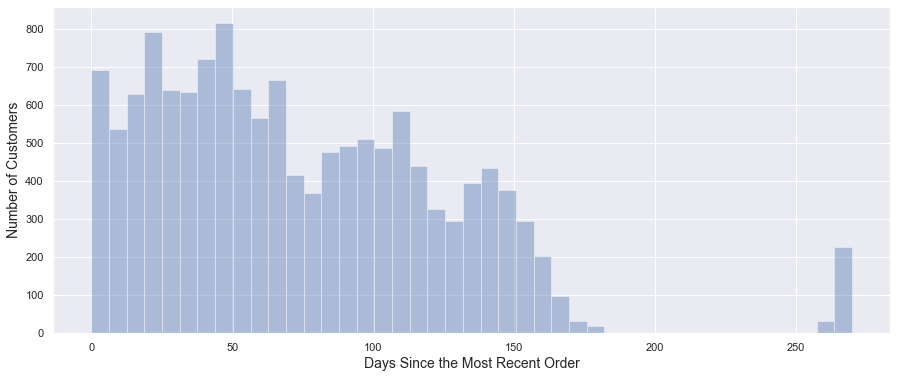

In [101]:
#### NOT REQUIRED FOR HW

sns.set(style='darkgrid')

# adjust the plot size
plt.figure().set_size_inches(15, 6)

# histogram
sns.distplot(cust_recency['order_recency'], kde=False)

# assign axis labels
plt.ylabel('Number of Customers', fontsize=14)
plt.xlabel('Days Since the Most Recent Order', fontsize=14);

Let's take a look at the cumulative distribution of customers by recency.

In [102]:
#Calculate Customer recency distribution
recency_distr = cust_recency.groupby('order_recency').size().reset_index()
recency_distr = recency_distr.rename(columns={0: 'cust_count'})
recency_distr.head()

,order_recency,cust_count
0,0,93
1,1,108
2,2,117
3,3,140
4,4,65


In [103]:
# calculate cumulative percentages 
cum_pctg = recency_distr['cust_count'].cumsum() / sum(recency_distr['cust_count'])
cum_pctg.head()

0    0.006712
1    0.014507
2    0.022952
3    0.033057
4    0.037748
Name: cust_count, dtype: float64

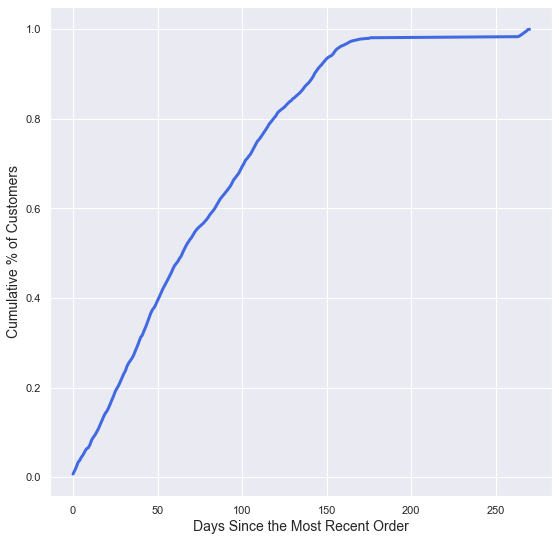

In [104]:
#### NOT REQUIRED FOR HW

sns.set(style='darkgrid')

# adjust the plot size
plt.figure().set_size_inches(9, 9)

# histogram
sns.lineplot(x=recency_distr['order_recency'], y=cum_pctg, color='royalblue', lw=3)

# assign axis labels
plt.ylabel('Cumulative % of Customers', fontsize=14)
plt.xlabel('Days Since the Most Recent Order', fontsize=14);

Additional eligibility criteria can be applied to exclude customers (from the modeling dataset) who have not shopped in more than, e.g., one/two years.

### Attribute #2: Number of orders per customer

In [105]:
# Count total records (i.e., orders) per customer
cust_orders = df_raw.groupby('customer_unique_id').size().reset_index().rename(columns={0: 'total_orders'})
cust_orders.head()

,customer_unique_id,total_orders
0,0000f46a3911fa3c0805444483337064,1
1,0005e1862207bf6ccc02e4228effd9a0,1
2,00115fc7123b5310cf6d3a3aa932699e,1
3,0011805441c0d1b68b48002f1d005526,1
4,0011857aff0e5871ce5eb429f21cdaf5,1


### Attribute #3: Weekday

In [106]:
df_raw.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_dow,waiting,customer_zip_code_prefix,payment_sequential,payment_installments,boleto,voucher,credit_card,total_purchase
25485,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,Friday,26.0,88115,1,8,0.0,0.0,1.0,689.76
68602,0005e1862207bf6ccc02e4228effd9a0,ae76bef74b97bcb0b3e355e60d9a6f9c,2017-03-04 23:32:12,Saturday,5.0,25966,1,3,0.0,0.0,1.0,450.36
41258,00115fc7123b5310cf6d3a3aa932699e,91d1bf2b7745903cb0d17162d1bbd750,2017-01-21 21:58:35,Saturday,11.0,71015,1,1,0.0,0.0,1.0,76.11
67499,0011805441c0d1b68b48002f1d005526,fb5d8b462dc9570527eff204b8a1a57b,2017-04-24 13:36:48,Monday,18.0,68639,1,10,0.0,0.0,1.0,2971.40
33688,0011857aff0e5871ce5eb429f21cdaf5,58d34816de3da57e9e07d7b34aced1b8,2017-06-28 11:08:38,Wednesday,8.0,9070,1,3,0.0,0.0,1.0,578.49


In [107]:
# get dummies
df_raw = pd.get_dummies(df_raw, columns=['order_dow'])
df_raw.head()

,customer_unique_id,order_id,order_purchase_timestamp,waiting,customer_zip_code_prefix,payment_sequential,payment_installments,boleto,voucher,credit_card,total_purchase,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday
25485,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,26.0,88115,1,8,0.0,0.0,1.0,689.76,1,0,0,0,0,0,0
68602,0005e1862207bf6ccc02e4228effd9a0,ae76bef74b97bcb0b3e355e60d9a6f9c,2017-03-04 23:32:12,5.0,25966,1,3,0.0,0.0,1.0,450.36,0,0,1,0,0,0,0
41258,00115fc7123b5310cf6d3a3aa932699e,91d1bf2b7745903cb0d17162d1bbd750,2017-01-21 21:58:35,11.0,71015,1,1,0.0,0.0,1.0,76.11,0,0,1,0,0,0,0
67499,0011805441c0d1b68b48002f1d005526,fb5d8b462dc9570527eff204b8a1a57b,2017-04-24 13:36:48,18.0,68639,1,10,0.0,0.0,1.0,2971.40,0,1,0,0,0,0,0
33688,0011857aff0e5871ce5eb429f21cdaf5,58d34816de3da57e9e07d7b34aced1b8,2017-06-28 11:08:38,8.0,9070,1,3,0.0,0.0,1.0,578.49,0,0,0,0,0,0,1


In [108]:
cust_dow = df_raw.drop(['order_id','order_purchase_timestamp'], axis=1)
cust_dow.head()

,customer_unique_id,waiting,customer_zip_code_prefix,payment_sequential,payment_installments,boleto,voucher,credit_card,total_purchase,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday
25485,0000f46a3911fa3c0805444483337064,26.0,88115,1,8,0.0,0.0,1.0,689.76,1,0,0,0,0,0,0
68602,0005e1862207bf6ccc02e4228effd9a0,5.0,25966,1,3,0.0,0.0,1.0,450.36,0,0,1,0,0,0,0
41258,00115fc7123b5310cf6d3a3aa932699e,11.0,71015,1,1,0.0,0.0,1.0,76.11,0,0,1,0,0,0,0
67499,0011805441c0d1b68b48002f1d005526,18.0,68639,1,10,0.0,0.0,1.0,2971.40,0,1,0,0,0,0,0
33688,0011857aff0e5871ce5eb429f21cdaf5,8.0,9070,1,3,0.0,0.0,1.0,578.49,0,0,0,0,0,0,1


### Combine all attributes into a single dataframe

In [109]:
# let's check the number of records in each dataframe first
cust_recency.shape, cust_orders.shape, cust_dow.shape

((13855, 2), (13855, 2), (14199, 16))

In [110]:
# combine (merge) `cust_recency` with `cust_orders` so that we have both attributes in one dataset
df = pd.merge(cust_recency, cust_orders, on='customer_unique_id').merge(cust_dow, on='customer_unique_id')
len(df)

14199

In [111]:
df.head()

,customer_unique_id,order_recency,total_orders,waiting,customer_zip_code_prefix,payment_sequential,payment_installments,boleto,voucher,credit_card,total_purchase,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday
0,0000f46a3911fa3c0805444483337064,112,1,26.0,88115,1,8,0.0,0.0,1.0,689.76,1,0,0,0,0,0,0
1,0005e1862207bf6ccc02e4228effd9a0,118,1,5.0,25966,1,3,0.0,0.0,1.0,450.36,0,0,1,0,0,0,0
2,00115fc7123b5310cf6d3a3aa932699e,160,1,11.0,71015,1,1,0.0,0.0,1.0,76.11,0,0,1,0,0,0,0
3,0011805441c0d1b68b48002f1d005526,67,1,18.0,68639,1,10,0.0,0.0,1.0,2971.40,0,1,0,0,0,0,0
4,0011857aff0e5871ce5eb429f21cdaf5,2,1,8.0,9070,1,3,0.0,0.0,1.0,578.49,0,0,0,0,0,0,1


Exclude customers who have not placed an order within the past one year.

In [112]:
df = df[df['order_recency'] <= 365]
len(df)

14199

In [113]:
df.to_csv('df.csv',index=False)

In [114]:
# iterating the columns to show all available attributes created for the data set above:
#Payment seq,Payment installment,Total purchase,Waiting,Zip code,Boleto,Voucher,Credit card
for col in df.columns: 
    print(col)

customer_unique_id
order_recency
total_orders
waiting
customer_zip_code_prefix
payment_sequential
payment_installments
boleto
voucher
credit_card
total_purchase
order_dow_Friday
order_dow_Monday
order_dow_Saturday
order_dow_Sunday
order_dow_Thursday
order_dow_Tuesday
order_dow_Wednesday


### Question #3: Create the dependent variable, purch, using the following definition: did the customer make at least one purchase during the prediction window? If a customer did make a purchase within the prediction window, then set purch to 1, otherwise set it to 0. (This is the same definition that we used in the class.)

### Assign labels (aka the target variable or the dependent variable)

For this exercise, we will assume that the objective of the model is to predict whether a customer will make *at least one purchase* in the future (i.e., within the target window of the model).

**Step 1:** Isolate all orders that were placed within the prediction window.

In [115]:
start_date = '06-30-2017'
end_date = '08-01-2018'
mask = (orders['order_purchase_timestamp'] > start_date) & (orders['order_purchase_timestamp'] <= end_date)

target_events_raw = orders[mask]

len(target_events_raw)

76020

In [116]:
target_events_raw
target_events_raw.to_csv('tgt.csv',index=False)
df.to_csv('df.csv',index=False)

In [117]:
# confirm the min and max dates are within the month of August 2018

print (target_events_raw['order_purchase_timestamp'].min(), target_events_raw['order_purchase_timestamp'].max())

2017-06-30 00:42:53 2018-07-31 23:54:20


**Step 2:** Summarize data to get one record per customer.

In [118]:
# count the number of orders (we will convert this into a binary flag later)

target_events = target_events_raw.groupby('customer_unique_id').size().reset_index().rename(columns={0: 'purch'})

target_events.head()

,customer_unique_id,purch
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f6ccb0745a6a4b88665a16c9f078,1
3,0004aac84e0df4da2b147fca70cf8255,1
4,0004bd2a26a76fe21f786e4fbd80607f,1


In [119]:
print(f'Number of customers who made at least one purchase durnig the prediction window: {len(target_events):,}')

Number of customers who made at least one purchase durnig the prediction window: 73,831


**Step 3:** Merge this dataframe with the `attr` dataframe to create the modeling dataset.

In [120]:
# merge `target_events` with the dataframe that contains customer attributes

df = pd.merge(df, target_events, how='left', on='customer_unique_id')

df.shape

(14199, 19)

In [121]:
df.head()

,customer_unique_id,order_recency,total_orders,waiting,customer_zip_code_prefix,payment_sequential,payment_installments,boleto,voucher,credit_card,total_purchase,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday,purch
0,0000f46a3911fa3c0805444483337064,112,1,26.0,88115,1,8,0.0,0.0,1.0,689.76,1,0,0,0,0,0,0,NaN
1,0005e1862207bf6ccc02e4228effd9a0,118,1,5.0,25966,1,3,0.0,0.0,1.0,450.36,0,0,1,0,0,0,0,NaN
2,00115fc7123b5310cf6d3a3aa932699e,160,1,11.0,71015,1,1,0.0,0.0,1.0,76.11,0,0,1,0,0,0,0,NaN
3,0011805441c0d1b68b48002f1d005526,67,1,18.0,68639,1,10,0.0,0.0,1.0,2971.40,0,1,0,0,0,0,0,NaN
4,0011857aff0e5871ce5eb429f21cdaf5,2,1,8.0,9070,1,3,0.0,0.0,1.0,578.49,0,0,0,0,0,0,1,NaN


In [122]:
df.purch.value_counts()

1.0     445
2.0      40
3.0       5
11.0      1
5.0       1
4.0       1
Name: purch, dtype: int64

We need to convert this variable into a binary flag.

**Step 4:** Set the target variable to 1 if at least one purchase was made, 0 otherwise.

In [123]:
# create the binary target flag

df['purch'] = [1 if x > 0 else 0 for x in df['purch']]

df.purch.value_counts()

0    13706
1      493
Name: purch, dtype: int64

In [124]:
# % distribution of the target flag

df.purch.value_counts() / len(df)

0    0.965279
1    0.034721
Name: purch, dtype: float64

There are two issues here: (1) the target event is extremely rare, and (2) the number of target events is also extremely small. There are several ways to circumvent these issues, but for now we will proceed with this dataset. 

In [125]:
# check the correlations

df.corr()['purch']

order_recency              -0.080542
total_orders                0.027830
waiting                    -0.012079
customer_zip_code_prefix    0.000500
payment_sequential         -0.005086
payment_installments        0.035238
boleto                     -0.019485
voucher                     0.005221
credit_card                 0.018997
total_purchase              0.006867
order_dow_Friday            0.080240
order_dow_Monday           -0.030008
order_dow_Saturday         -0.011716
order_dow_Sunday           -0.009910
order_dow_Thursday         -0.007923
order_dow_Tuesday          -0.020309
order_dow_Wednesday         0.001530
purch                       1.000000
Name: purch, dtype: float64

Before moving on to model building, lets create a two-axis plot to view the purchase rates by recency.

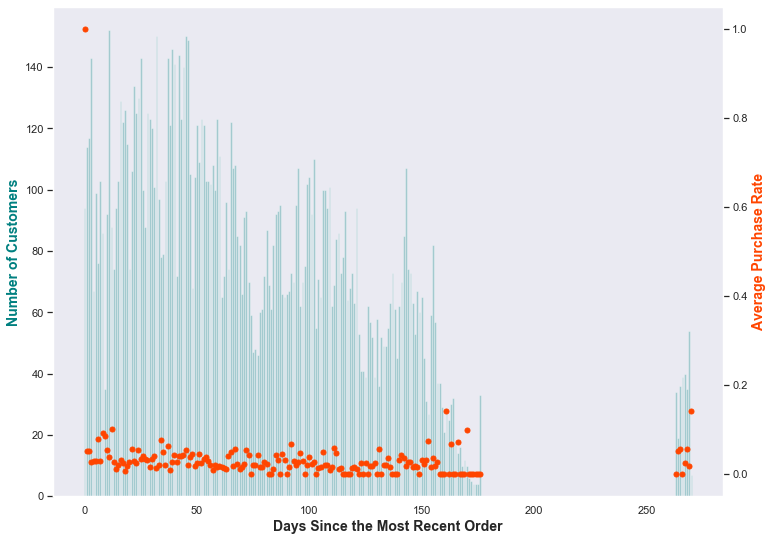

In [126]:
purch_rate_by_recency = df.groupby('order_recency')['purch'].mean().reset_index()
purch_rate_by_recency['orders'] = df.groupby('order_recency').size().reset_index()[0]

sns.set(style = 'dark')
f, ax = plt.subplots(figsize = (12, 9))

ax2 = ax.twinx()

ax.bar(purch_rate_by_recency['order_recency'], purch_rate_by_recency['orders'], color='teal', alpha=0.3)

ax2.plot(purch_rate_by_recency['order_recency'], purch_rate_by_recency['purch'], 
         color='orangered', marker='o', markersize=5, lw=0)

#ax2.set_ylabel('Average Populatiry', fontsize = 14, color='orangered', weight='bold')
ax.set_xlabel('Days Since the Most Recent Order', fontsize=14, weight='bold')
ax.set_ylabel('Number of Customers', fontsize=14, weight='bold', color='teal')
ax2.set_ylabel('Average Purchase Rate', fontsize = 14, color='orangered', weight='bold')

plt.show()

In [127]:
purch_rate_by_recency.head()

,order_recency,purch,orders
0,0,1.000000,94
1,1,0.052632,114
2,2,0.051282,117
3,3,0.027972,143
4,4,0.029851,67


### Questions#4. Split the modeling set into two equal partitions: ‘train’ and ‘test’.
#### a) For 2 extra credits: Perform this task without using the sklearn.model_selection.train_test_split() function

In [128]:
df.columns

Index(['customer_unique_id', 'order_recency', 'total_orders', 'waiting',
       'customer_zip_code_prefix', 'payment_sequential',
       'payment_installments', 'boleto', 'voucher', 'credit_card',
       'total_purchase', 'order_dow_Friday', 'order_dow_Monday',
       'order_dow_Saturday', 'order_dow_Sunday', 'order_dow_Thursday',
       'order_dow_Tuesday', 'order_dow_Wednesday', 'purch'],
      dtype='object')

In [129]:
df.describe()

,order_recency,total_orders,waiting,customer_zip_code_prefix,payment_sequential,payment_installments,boleto,voucher,credit_card,total_purchase,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday,purch
count,14199.000000,14199.000000,14198.000000,14199.000000,14199.000000,14199.000000,14199.000000,14199.000000,14199.00000,14199.000000,14199.000000,14199.000000,14199.000000,14199.000000,14199.000000,14199.000000,14199.000000,14199.000000
mean,74.564617,1.053807,12.870545,37111.392070,1.226354,3.152757,0.216776,0.045003,0.75618,720.248598,0.138038,0.161702,0.108458,0.122614,0.155081,0.158814,0.155293,0.034721
std,52.510129,0.269198,10.643963,30060.565193,4.129698,2.856990,0.412063,0.207318,0.42940,1954.655539,0.344952,0.368190,0.310969,0.328005,0.361995,0.365515,0.362196,0.183078
min,0.000000,1.000000,0.000000,1004.000000,1.000000,1.000000,0.000000,0.000000,0.00000,11.620000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,1.000000,8.000000,13042.000000,1.000000,1.000000,0.000000,0.000000,1.00000,79.620000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65.000000,1.000000,11.000000,27521.000000,1.000000,2.000000,0.000000,0.000000,1.00000,193.260000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,110.000000,1.000000,15.000000,64000.500000,1.000000,4.000000,0.000000,0.000000,1.00000,591.630000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,270.000000,6.000000,210.000000,99950.000000,351.000000,18.000000,1.000000,1.000000,1.00000,55434.480000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [130]:
#df[df['waiting'].isnull()]['waiting']
df.loc[df['waiting'].isnull(),'waiting']=0

In [131]:
# set-up

preds = df.columns[1:-1]

X = df[preds]
y = df['purch']

Tri-fold partitioning is recommended as long as there's sufficient sample size avaiable. In this example, since the number of target events is very small, we will perform a two-fold paritioning of the modeling sample.

Note that we could increase the size of the prediction window to capture more purchase events. However, for this exercise we will continue with the current prediction window (of one month).

#### Two-fold partition

In [171]:
# # split the dataframe into train(50%) and test(50%)
# To confirm analysis, run the code below to confirm they are equal...

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=314)

# len(X_train), len(X_test)

In [133]:
msk = np.random.rand(len(df)) < 0.8

X_train = X[msk]

X_test = X[~msk]



y_train = y[msk]

y_test = y[~msk]

In [134]:
# target distribution in the trainig sample

y_train.value_counts()

0    10976
1      397
Name: purch, dtype: int64

In [135]:
# target distribution in the test sample

y_test.value_counts()

0    2730
1      96
Name: purch, dtype: int64

### Question #5. Build a Logistic Regression model using purch as the dependent (target) variable and include all attributes created in tasks #1 and #2 above as the independent variables in the model. Use the ‘train’ set for training the model.

In [136]:
from sklearn.linear_model import LogisticRegression

# define the model object ('liblinear' is recommended for small datasets)
clf = LogisticRegression(solver='liblinear', random_state=314)

# train (fit) the model using the training sample
clf.fit(X_train, y_train)

# make predictions on the test sample
y_preds = clf.predict(X_test)

### Question #7: Model accuracy.  Using the ‘test’ partition (created in task #4), to compare the performance of these two models using the following metrics:
#### a. AUC (Area Under the ROC Curve),
#### b. Confusion matrix,
#### c. Precision, and
#### d. Recall

In [137]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_preds)

0.9660297239915074

Why does the model appear to be very strong in spite of only two predictors that didn't look correlated with the target?

In [138]:
# a. Area under the ROC curve (AUC)
from sklearn.metrics import roc_auc_score

# calculate the probabilities on the test sample
y_scores = clf.predict_proba(X_test)[:, 1]

# calcualte AUC
roc_auc_score(y_test, y_scores)

0.6307883089133088

In [139]:
# check model's predictions against actual value of the target event
# b. Confusion Matrix
confusion_matrix=pd.crosstab(y_test, y_preds)
confusion_matrix

col_0,0
purch,
0,2730
1,96


In [140]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_preds)
cm

array([[2730,    0],
       [  96,    0]], dtype=int64)

The model is predicting 0 (no purchase) for all customers! Accuracy score is not a reliable measure while dealing with rare events. Let's take a look at a few additional metrics.

In [141]:
# c. Precision
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_scores)
average_precision

0.09480533520603929

In [142]:
# d. Recall
from sklearn.metrics import recall_score
recall_score(y_test, y_preds)

0.0

## Question #8
#### For 3 extra credits: Using the confusion matrix, calculate the misclassification rate for both models.The misclassification can be calculated by adding the false positive counts and the false negative counts and then dividing by the total number of records (samples).
#### a) Combine the predictions from both models in the following way: if both models predicn purch=1,     then set the prediction to 1, otherwise set it to 0. Create a confusion matrix from thisnew           “ensemble” model and calculate the mis-classification rate.


In [143]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_preds)


0.03397027600849257

In [144]:
misclassification=(cm[1][0]  + cm[0][1] )/len(y_test)
misclassification

0.03397027600849257

## Export results

#### 1. Scored dataset (with all model attributes)

In [145]:
scores_all = clf.predict_proba(df[preds])[:, 1]

df['prob_to_purchase'] = scores_all

df.head()

,customer_unique_id,order_recency,total_orders,waiting,customer_zip_code_prefix,payment_sequential,payment_installments,boleto,voucher,credit_card,total_purchase,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday,purch,prob_to_purchase
0,0000f46a3911fa3c0805444483337064,112,1,26.0,88115,1,8,0.0,0.0,1.0,689.76,1,0,0,0,0,0,0,0,0.003733
1,0005e1862207bf6ccc02e4228effd9a0,118,1,5.0,25966,1,3,0.0,0.0,1.0,450.36,0,0,1,0,0,0,0,0,0.023238
2,00115fc7123b5310cf6d3a3aa932699e,160,1,11.0,71015,1,1,0.0,0.0,1.0,76.11,0,0,1,0,0,0,0,0,0.006442
3,0011805441c0d1b68b48002f1d005526,67,1,18.0,68639,1,10,0.0,0.0,1.0,2971.40,0,1,0,0,0,0,0,0,0.012574
4,0011857aff0e5871ce5eb429f21cdaf5,2,1,8.0,9070,1,3,0.0,0.0,1.0,578.49,0,0,0,0,0,0,1,0,0.151367


In [146]:
csv_file_zipped = 'purch_model_scores.csv.gz'

df.to_csv(csv_file_zipped, compression='gzip')

#### 2. Export the model

In [147]:
import joblib

model_pkl_file = 'purch_model.joblib'

joblib.dump(clf, model_pkl_file)

['purch_model.joblib']

##### Load the model

In [148]:
clf_loaded = joblib.load(model_pkl_file)

clf_loaded

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=314, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [149]:
# use the model to score a "new" data frame

clf_loaded.predict_proba(X_test)

array([[0.97676158, 0.02323842],
       [0.78700246, 0.21299754],
       [0.9914427 , 0.0085573 ],
       ...,
       [0.98680817, 0.01319183],
       [0.99885698, 0.00114302],
       [0.99375446, 0.00624554]])

### Question 6: Repeat task #5 with a Decision Tree instead of Logistic Regression model. Specify at least two parameters to reduce the amount of over-fitting

In [150]:
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier(
                     random_state = 1337,
                     criterion = 'gini',
                     splitter = 'best',
                     max_depth = 5,
                     min_samples_leaf = 1
            )

In [151]:
# train (fit) the model using the training sample
%time clf_dt.fit(X_train, y_train)

# make predictions on the test sample
%time y_preds_dt = clf_dt.predict(X_test)

Wall time: 27.9 ms
Wall time: 998 µs


In [152]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_preds_dt)

0.97310686482661

In [153]:
confusion_matrix_dt = pd.crosstab(y_test, y_preds_dt)
confusion_matrix_dt

col_0,0,1
purch,,
0,2730,0
1,76,20


In [154]:
from sklearn.metrics import confusion_matrix
cm_dt=confusion_matrix(y_test, y_preds_dt)
cm_dt

array([[2730,    0],
       [  76,   20]], dtype=int64)

In [155]:
from sklearn.metrics import roc_auc_score

# calculate the probabilities on the test sample
y_scores_dt = clf_dt.predict_proba(X_test)[:, 1]

# calcualte AUC
roc_auc_score(y_test, y_scores_dt)

0.6496108058608058

In [156]:
from sklearn.metrics import average_precision_score

average_precision_dt = average_precision_score(y_test, y_scores_dt)

average_precision_dt

0.24213548529750115

In [157]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_preds_dt)


0.02689313517338995

In [158]:
misclassification_dt=(cm_dt[1][0]  + cm_dt[0][1] )/len(y_test)
misclassification_dt

0.02689313517338995

In [159]:
from sklearn.metrics import recall_score
recall_score(y_test, y_preds_dt)

0.20833333333333334

In [160]:
scores_all_dt = clf_dt.predict_proba(df[preds])[:, 1]

df['prob_to_purchase_dt'] = scores_all_dt

df.head()

,customer_unique_id,order_recency,total_orders,waiting,customer_zip_code_prefix,payment_sequential,payment_installments,boleto,voucher,credit_card,...,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday,purch,prob_to_purchase,prob_to_purchase_dt
0,0000f46a3911fa3c0805444483337064,112,1,26.0,88115,1,8,0.0,0.0,1.0,...,1,0,0,0,0,0,0,0,0.003733,0.022236
1,0005e1862207bf6ccc02e4228effd9a0,118,1,5.0,25966,1,3,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0.023238,0.022236
2,00115fc7123b5310cf6d3a3aa932699e,160,1,11.0,71015,1,1,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0.006442,0.022236
3,0011805441c0d1b68b48002f1d005526,67,1,18.0,68639,1,10,0.0,0.0,1.0,...,0,1,0,0,0,0,0,0,0.012574,0.022236
4,0011857aff0e5871ce5eb429f21cdaf5,2,1,8.0,9070,1,3,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,0.151367,0.034941


In [161]:
csv_file_zipped_dt = 'purch_model_scores_dt.csv.gz'

df.to_csv(csv_file_zipped_dt, compression='gzip')

In [162]:
import joblib

model_pkl_file_dt = 'purch_model_dt.joblib'

joblib.dump(clf_dt, model_pkl_file_dt)

['purch_model_dt.joblib']

In [163]:
clf_loaded_dt = joblib.load(model_pkl_file_dt)

clf_loaded_dt

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1337, splitter='best')

In [164]:
clf_loaded_dt.predict_proba(X_test)

array([[0.97776376, 0.02223624],
       [0.96505926, 0.03494074],
       [0.97776376, 0.02223624],
       ...,
       [0.97776376, 0.02223624],
       [0.97776376, 0.02223624],
       [0.97776376, 0.02223624]])

In [165]:
len(y_preds)

2826

In [166]:
len(y_preds_dt)

2826

In [167]:
dataset = pd.DataFrame({'y_test' : y_test, 'lr_preds': y_preds, 'dt_preds': y_preds_dt}, columns=['y_test','lr_preds', 'dt_preds'])


In [168]:
dataset.head(100)

,y_test,lr_preds,dt_preds
1,0,0,0
6,0,0,0
8,0,0,0
10,0,0,0
14,0,0,0
15,0,0,0
19,0,0,0
22,0,0,0
26,0,0,0
30,0,0,0


In [169]:
dataset.loc[np.logical_and(dataset['lr_preds'] == 1 ,  dataset['dt_preds'] == 1), 'f_preds'] = 1 
dataset.loc[dataset['f_preds'].isnull() , 'f_preds'] = 0


In [170]:
from sklearn.metrics import confusion_matrix
cm_a=confusion_matrix(dataset['y_test'], dataset['f_preds'])
cm_a

array([[2730,    0],
       [  96,    0]], dtype=int64)